#### Integrin

## setup

In [1]:
import os
import sys
import math
import time
import pickle
import copy
#import mdtraj
import MDAnalysis as mda
#import pyemma
#import pyemma.util.contexts
import networkx as nx
import random
#import parmed as pmd
#import acpype
import pandas as pd
from MDAnalysis.analysis import distances
from MDAnalysis.analysis import rms


import numpy as np
from scipy.linalg import eigh
from scipy.spatial.distance import pdist
from scipy.interpolate import interp1d
import matplotlib as mpl
from matplotlib import ticker
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import nglview as nv

import glob

no display found. Using non-interactive Agg backend


In [2]:

from importlib import reload 
import sys


#### plot settings

In [3]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

## load all strings

In [5]:
from MDAnalysis.analysis import rms

def cartesian_to_spherical(coords):
    coords = np.array(coords)
    x, y, z = coords[0], coords[1], coords[2]
    r = np.sqrt(x**2 + y**2 + z**2)    
    theta = np.arctan2(y, x)  # Range: (-π, π)
    if theta < 0:
        theta += 2 * np.pi  # Normalize to [0, 2π]
    # Calculate phi (polar angle)
    phi = np.arccos(np.clip(z / r, -1.0, 1.0))  # Avoid domain errors with np.clip
    
    theta_deg = np.degrees(theta)
    phi_deg = np.degrees(phi)
    
    return np.vstack((r, theta_deg, phi_deg)).T



NIMAGES=19
ag1_indices = 'index 14621 14756 14821 14918 15001 15087 15173 15213 15239 15273 15288 15312 15327 15342'
ag2_indices = 'index 25941 26024 26101 26204 26290 26357 26429 26502 26570 26608 26655 26713 26737 26762 26796 26829 26864 26895'
ag3_indices = 'index 57 149 253 379 465 550 621 686 761 865 928 1019 1135 1224 1381 1513 1645 1789 1896 2021 2139 2241 2365 2519 2657 2739 2812 2907 2984 3053 3116 3218 3325 3425 3512 3596 3711 3859 3958 4044 4145 4248 4338 4414 4481 4542 4621 4706 4804 4881 4929 5029 5141 5231 5361 5540 5742 5871 5983 6119 6230 6328 6428 6527 6600'
ag4_indices = 'index 24438 24573 24684 24764 24817 24873 24924 24985 25075 25140 25216 25279 25334 25416 25475 25515 25545 25601 25649 25698 25753 25823 25888'


simlocation = '/project2/andrewferguson/sivadasetty/doe/analysis-integrin/string_mechanisms/deadbolt/string_parallel_100k_full_lipid_case/final_string/'

spherical_vals = {}
for i in range(NIMAGES):
# for i in [0]:
        
    #mduniverse = mda.Universe(simlocation+ 'analyze_orient/target_md_' + str(i) + '/minimize-notwater-nocofactors.pdb')
    mduniverse = mda.Universe(simlocation+ 'analyze_orient/target_md_' + str(i) + '/minimize-notwater-nocofactors_CA_aligned0Plane.pdb')
    
    ag1 = mduniverse.atoms.select_atoms(ag1_indices)
    ag2 = mduniverse.atoms.select_atoms(ag2_indices)
    ag3 = mduniverse.atoms.select_atoms(ag3_indices)
    ag4 = mduniverse.atoms.select_atoms(ag4_indices)
    
    
    beta_propeller = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 1 to 452')
    thigh = mduniverse.select_atoms('segid is A  and name is CA').atoms.select_atoms('resid 453 to 608')
    calf_1 = mduniverse.select_atoms('segid is A and name is CA ').atoms.select_atoms('resid 609 to 743')
    calf_2 = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 744 to 964')
    alpha_transmembrane = mduniverse.select_atoms('segid is A and name is CA').atoms.select_atoms('resid 965 to 1008')

    beta_1 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 110 to 352')
    hyb = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 58 to 109 or resid 353 to 452')
    psi = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 1 to 57')
    e1 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 433 to 475')
    e2 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 476 to 525')
    e3 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 526 to 560')
    e4 = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 561 to 604')
    beta_t = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 604 to 690')
    beta_transmembrane = mduniverse.select_atoms('segid is B and name is CA').atoms.select_atoms('resid 691 to 772')

    #print(beta_propeller)
    
    domains_present = {}
    # Get COM
    if beta_propeller:
        domains_present['beta_propeller_com'] = beta_propeller.center_of_mass(wrap=False, unwrap=False, compound='group')
    if thigh:
        domains_present['thigh_com'] = thigh.center_of_mass(wrap=False, unwrap=False, compound='group')
    if calf_1:
        domains_present['calf_1_com'] = calf_1.center_of_mass(wrap=False, unwrap=False, compound='group')
    if calf_2:
        domains_present['calf_2_com'] = calf_2.center_of_mass(wrap=False, unwrap=False, compound='group')
    if alpha_transmembrane:
        domains_present['alpha_transmembrane_com'] = alpha_transmembrane.center_of_mass(wrap=False, unwrap=False, compound='group')

    if beta_1:
        domains_present['beta_1_com'] = beta_1.center_of_mass(wrap=False, unwrap=False, compound='group')
    if hyb:
        domains_present['hyb_com'] = hyb.center_of_mass(wrap=False, unwrap=False, compound='group')
    if psi:
        domains_present['psi_com'] = psi.center_of_mass(wrap=False, unwrap=False, compound='group')
    if e1:
        domains_present['e1_com'] = e1.center_of_mass(wrap=False, unwrap=False, compound='group')
    if e2:
        domains_present['e2_com'] = e2.center_of_mass(wrap=False, unwrap=False, compound='group')
    if e3:
        domains_present['e3_com'] = e3.center_of_mass(wrap=False, unwrap=False, compound='group')
    if e4:
        domains_present['e4_com'] = e4.center_of_mass(wrap=False, unwrap=False, compound='group')
    if beta_t:
        domains_present['beta_t_com'] = beta_t.center_of_mass(wrap=False, unwrap=False, compound='group')
    if beta_transmembrane:
        domains_present['beta_transmembrane_com'] = beta_transmembrane.center_of_mass(wrap=False, unwrap=False, compound='group')

        
                
    # Calculate r, theta, and phi with origin
    # vec_betaPropeller_thigh, vec_calf1_calf2, vec_psi_betaA, vec_e4_e1
    
    vec_betaPropeller = domains_present['beta_propeller_com'] #domains_present['thigh_com'] - domains_present['beta_propeller_com']
    vec_calf1= domains_present['calf_1_com'] #domains_present['calf_2_com'] - domains_present['calf_1_com']
    
    vec_betaA = domains_present['beta_1_com'] #domains_present['psi_com'] - domains_present['beta_1_com']
    vec_e1 = domains_present['e1_com'] #domains_present['e4_com'] - domains_present['e1_com']
    
    spherical_betaPropeller = cartesian_to_spherical(vec_betaPropeller)
    spherical_calf1 = cartesian_to_spherical(vec_calf1)
    spherical_betaA = cartesian_to_spherical(vec_betaA)
    spherical_e1 = cartesian_to_spherical(vec_e1)
    
    
    spherical_vals[i] = {'beta_propeller': spherical_betaPropeller, 'calf1': spherical_calf1,
                         'betaA': spherical_betaA, 'e1': spherical_e1}
    


In [6]:
## swap inner outer keys; also change from Angstrom to nm

def swap_inner_outer_keys(data):
    result = {}
    for outer_key, inner_dict in data.items():
        for inner_key, value in inner_dict.items():
            result.setdefault(inner_key, {})[outer_key] = value
    return result

swap_spherical_vals = swap_inner_outer_keys(spherical_vals)


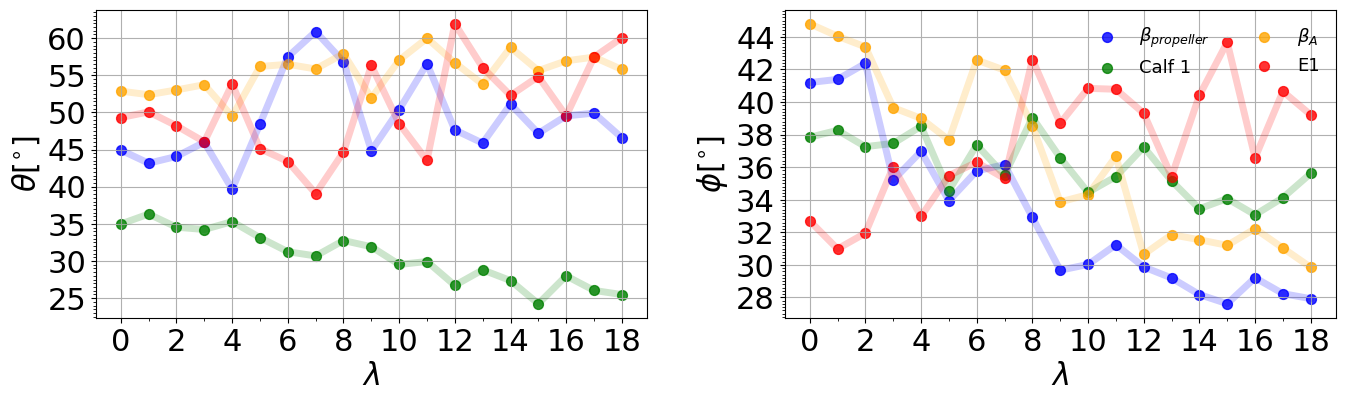

In [13]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator


################################################################################################

font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=(16,4))


rows=1
cols=2

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.15, wspace=0.25)


################################################################################################
# Bent to Int1
ax = fig.add_subplot(gs[0])

nstart = 0
ncolors = 8 #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

# r
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,0]/10
# theta 
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='blue')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='blue')


# theta 
plot_data = np.array(list(swap_spherical_vals['calf1'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='green')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='green')

# theta 
plot_data = np.array(list(swap_spherical_vals['betaA'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='orange')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='orange')


# theta 
plot_data = np.array(list(swap_spherical_vals['e1'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='red')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='red')


# for i in range(nstart,ncolors):
#     ax.plot(list(swap_rmsd_iterations[i].keys()), 
#             list(swap_rmsd_iterations[i].values()), color=colors[i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

# ax.set_title('Bent-closed to Int1 state', fontsize=15)

ax.set_ylabel(r'$\theta$[$^{\circ}$]')
ax.set_xlabel('$\lambda$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(10))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.grid()

################################################################################################
ax = fig.add_subplot(gs[1])

# theta 
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='blue')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='blue', label =r'$\beta_{propeller}$')


# theta 
plot_data = np.array(list(swap_spherical_vals['calf1'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='green')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='green', label =r'Calf 1')


# theta 
plot_data = np.array(list(swap_spherical_vals['betaA'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='orange')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='orange', label =r'$\beta_{A}$')


# theta 
plot_data = np.array(list(swap_spherical_vals['e1'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='red')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='red', label ='E1')


ax.set_ylabel(r'$\phi$[$^{\circ}$]')
ax.set_xlabel('$\lambda$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(10))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.legend(frameon=False, ncol=2, fontsize=13)
ax.grid()


### aligned analysis

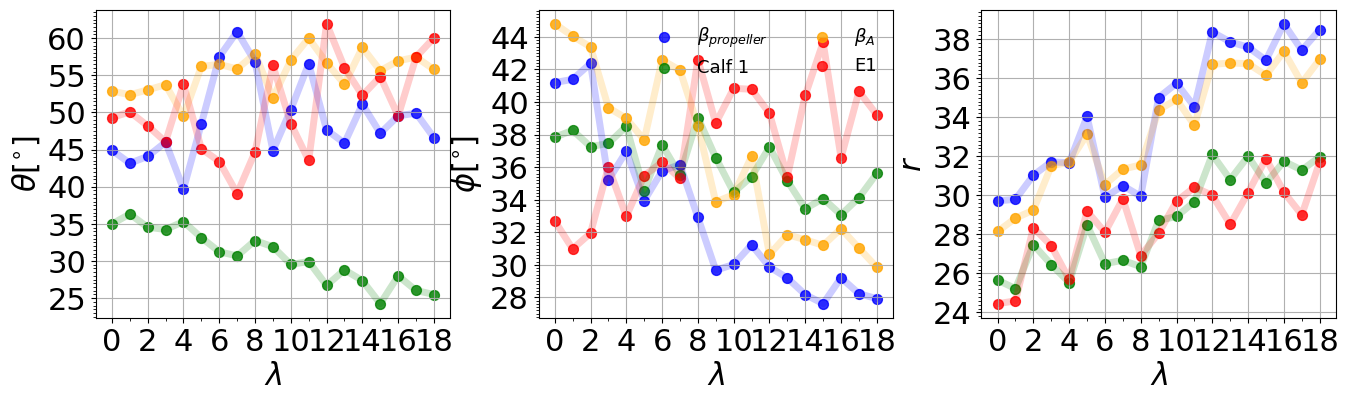

In [12]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator


################################################################################################

font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=(16,4))


rows=1
cols=3

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.15, wspace=0.25)


################################################################################################
# Bent to Int1
ax = fig.add_subplot(gs[0])

nstart = 0
ncolors = 8 #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

# r
#plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,0]/10

# theta 
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='blue')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='blue')


# theta 
plot_data = np.array(list(swap_spherical_vals['calf1'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='green')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='green')

# theta 
plot_data = np.array(list(swap_spherical_vals['betaA'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='orange')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='orange')


# theta 
plot_data = np.array(list(swap_spherical_vals['e1'].values())).squeeze(1)[:,1]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='red')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='red')


# for i in range(nstart,ncolors):
#     ax.plot(list(swap_rmsd_iterations[i].keys()), 
#             list(swap_rmsd_iterations[i].values()), color=colors[i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

# ax.set_title('Bent-closed to Int1 state', fontsize=15)

ax.set_ylabel(r'$\theta$[$^{\circ}$]')
ax.set_xlabel('$\lambda$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(10))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.grid()



################################################################################################
ax = fig.add_subplot(gs[1])

# phi 
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='blue')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='blue', label =r'$\beta_{propeller}$')


# phi 
plot_data = np.array(list(swap_spherical_vals['calf1'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='green')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='green', label =r'Calf 1')


# phi 
plot_data = np.array(list(swap_spherical_vals['betaA'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='orange')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='orange', label =r'$\beta_{A}$')


# phi 
plot_data = np.array(list(swap_spherical_vals['e1'].values())).squeeze(1)[:,2]
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='red')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='red', label ='E1')


ax.set_ylabel(r'$\phi$[$^{\circ}$]')
ax.set_xlabel('$\lambda$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(10))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.legend(frameon=False, ncol=2, fontsize=13)
ax.grid()


################################################################################################
# Bent to Int1
ax = fig.add_subplot(gs[2])

nstart = 0
ncolors = 8 #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

# r
#plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,0]/10

# theta 
plot_data = np.array(list(swap_spherical_vals['beta_propeller'].values())).squeeze(1)[:,0]/10
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='blue')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='blue')


# theta 
plot_data = np.array(list(swap_spherical_vals['calf1'].values())).squeeze(1)[:,0]/10
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='green')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='green')

# theta 
plot_data = np.array(list(swap_spherical_vals['betaA'].values())).squeeze(1)[:,0]/10
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='orange')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='orange')


# theta 
plot_data = np.array(list(swap_spherical_vals['e1'].values())).squeeze(1)[:,0]/10
ax.plot(np.arange(len(plot_data)), plot_data, lw=5, alpha=0.2, color='red')
ax.scatter(np.arange(len(plot_data)), plot_data, s=50, alpha=0.8, color='red')


# for i in range(nstart,ncolors):
#     ax.plot(list(swap_rmsd_iterations[i].keys()), 
#             list(swap_rmsd_iterations[i].values()), color=colors[i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

# ax.set_title('Bent-closed to Int1 state', fontsize=15)

ax.set_ylabel(r'$r$')
ax.set_xlabel('$\lambda$')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(10))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.grid()






In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, MultipleLocator, AutoMinorLocator


################################################################################################

font = {'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=(16,4))


rows=1
cols=3

count_figs = 0
gs = gridspec.GridSpec(rows, cols, hspace=0.15, wspace=0.35)


################################################################################################
# Bent to Int1
ax = fig.add_subplot(gs[0])

nstart = 0
ncolors = 8 #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

for i in range(nstart,ncolors):
    ax.plot(list(swap_rmsd_iterations[i].keys()), 
            list(swap_rmsd_iterations[i].values()), color=colors[i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

# ax.set_title('Bent-closed to Int1 state', fontsize=15)
ax.legend(frameon=False, ncol=3, fontsize=10)
ax.set_ylabel('RMSD [nm]')
ax.set_xlabel('Iteration')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(5))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

################################################################################################
# Int1 to Int2
ax = fig.add_subplot(gs[1])

nstart = ncolors
ncolors = 12 #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

count_i=0
for i in range(nstart,ncolors):
    ax.plot(list(swap_rmsd_iterations[i].keys()), 
            list(swap_rmsd_iterations[i].values()), color=colors[count_i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

    count_i+=1
   
# ax.set_title('Int1 to Int2 state', fontsize=15)
ax.legend(frameon=False, ncol=3, fontsize=10)
ax.set_ylabel('RMSD [nm]')
ax.set_xlabel('Iteration')
ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(5))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))

################################################################################################
# Int2 to Open
ax = fig.add_subplot(gs[2])

nstart = ncolors
ncolors = NIMAGES #6
values = np.linspace(0, 1, ncolors-nstart)
colors = plt.get_cmap('jet')(values)

count_i=0
for i in range(nstart,ncolors):
    ax.plot(list(swap_rmsd_iterations[i].keys()), 
            list(swap_rmsd_iterations[i].values()), color=colors[count_i], lw=5, alpha=0.65, label=r'$\lambda$='+str(i))

    count_i+=1
    
# ax.set_title('Int2 to extended-open state', fontsize=15)
ax.legend(frameon=False, ncol=3, fontsize=10)
ax.set_ylabel('RMSD [nm]')
ax.set_xlabel('Iteration')

ax.yaxis.set_major_locator(MaxNLocator(10))    
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))

ax.xaxis.set_major_locator(MaxNLocator(5))    
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
